In [32]:
from torchvision.transforms import Resize
import torch
from datasets import load_dataset
from transformers import AutoImageProcessor, AutoModel
import matplotlib.pyplot as plt

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-large')
model = AutoModel.from_pretrained('facebook/dinov2-large')

ds = load_dataset("timm/oxford-iiit-pet")

In [33]:
images = ds["train"]["image"]
inputs = processor(images=images, return_tensors="pt")

Analyze the attention heads

In [34]:
# Normalize an image for display
def normalize_for_display(img):
    img = img - img.min()
    img = img / img.max()
    return img

In [35]:
print(inputs["pixel_values"].shape)

torch.Size([3680, 3, 224, 224])


Visualizing attention for image 1...
torch.Size([1, 257, 1024])
torch.Size([256, 256])


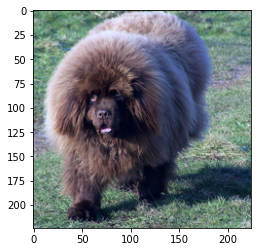

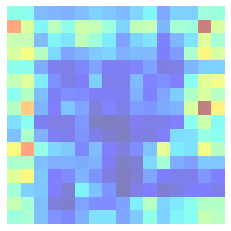

Visualizing attention for image 2...
torch.Size([1, 257, 1024])
torch.Size([256, 256])


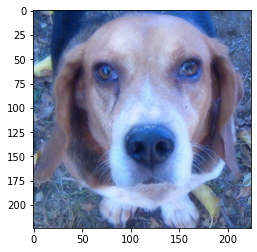

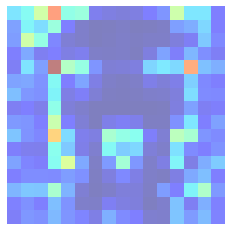

Visualizing attention for image 3...
torch.Size([1, 257, 1024])
torch.Size([256, 256])


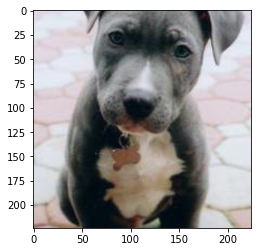

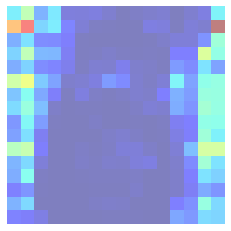

In [64]:
# Global variable to store raw attention weights
captured_attention_weights = None

# Hook function to capture attention weights
def wrapped_attention_hook(module, input, output):
    global captured_attention_weights
    Q = module.query(input[0])
    K = module.key(input[0])

    print(Q.shape)
    # Compute attention
    batch_size, seq_len, hidden_size = Q.shape
    num_heads = model.config.num_attention_heads
    head_dim = model.config.hidden_size // num_heads

    Q = Q.view(batch_size, seq_len, num_heads, head_dim).permute(0, 2, 1, 3)
    K = K.view(batch_size, seq_len, num_heads, head_dim).permute(0, 2, 1, 3)
    attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (head_dim ** 0.5)
    captured_attention_weights = torch.nn.functional.softmax(attention_scores, dim=-1)

# Normalize images for display
def normalize_for_display(img):
    img = img - img.min()
    img = img / img.max()
    return img

# Function to visualize attention
def visualize_attention(image, selected_layer=-1, selected_head=0, threshold=0.8, apply_threshold=True):
    global captured_attention_weights

    # Clear previous weights
    captured_attention_weights = None

    # Get the selected layer's attention
    layer_attention = model.encoder.layer[selected_layer].attention.attention

    # Register the hook and perform forward pass
    hook = layer_attention.register_forward_hook(wrapped_attention_hook)
    model(image.unsqueeze(0))  # Forward pass
    hook.remove()  # Remove the hook

    # Verify attention weights are captured
    if captured_attention_weights is None:
        print("Error: Attention weights not captured!")
        return

    # Extract attention for the selected head or aggregate across heads
    attention_map = captured_attention_weights[0, selected_head, 1:, 1:]  # Patch tokens only
    print(attention_map.shape)

    # Aggregate attention for each patch
    patch_attention = attention_map[2]  # Average attention across all other patches

    # Reshape into a 14x14 grid
    patch_attention_2d = patch_attention.view(16, 16)

    # Normalize the attention map
    patch_attention_2d -= patch_attention_2d.min()
    patch_attention_2d /= patch_attention_2d.max()

    # Resize to match image dimensions
    resize = Resize((image.shape[-2], image.shape[-1]))
    attention_map_resized = resize(patch_attention_2d.unsqueeze(0).unsqueeze(0))

    # original image
    original_image = normalize_for_display(image.permute(1, 2, 0))

    # Overlay the attention map on the image
    # plt.imshow(normalize_for_display(image.permute(1, 2, 0)))  # Original image
    # plt.imshow(attention_map_resized.squeeze().detach().cpu().numpy(), cmap="jet", alpha=0.5)  # Overlay heatmap
    plt.imshow(original_image)
    # now shoe a new plot that is the attention map
    plt.figure()
    plt.imshow(patch_attention_2d.squeeze().detach().cpu().numpy(), cmap="jet", alpha=0.5)  # Overlay heatmap
    plt.axis("off")
    plt.show()
    # genreate new image with attention map

# Analyze attention for different images
# images = [inputs["pixel_values"][122, :, :, :], inputs["pixel_values"][123, :, :, :]]
images = [inputs["pixel_values"][122, :, :, :], inputs["pixel_values"][123, :, :, :], inputs["pixel_values"][124, :, :, :]]

for idx, img in enumerate(images):
    print(f"Visualizing attention for image {idx + 1}...")
    visualize_attention(img, selected_layer=1, selected_head=8, threshold=0.5, apply_threshold=True)  # Change head/layer as needed

